In [1]:
import numpy as np

In [2]:
data_dict=np.load('out_10M.npz',allow_pickle=True)
data_dict

NpzFile 'out_10M.npz' with keys: data, nq, model_xml, site_name

In [3]:
nq = data_dict['nq'].item()
nq, data_dict['data'].shape

(8, (10000000, 15))

In [4]:
GRIPPER_DOFS = 2
joint_angles = data_dict['data'][:,:nq-GRIPPER_DOFS]
ee_pos_quat = data_dict['data'][:,nq:]
joint_angles.shape, ee_pos_quat.shape

((10000000, 6), (10000000, 7))

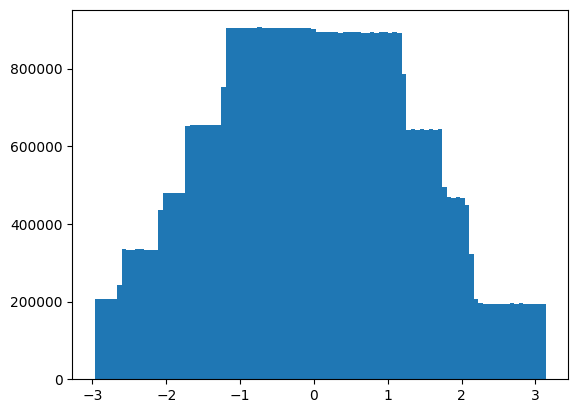

In [5]:
import matplotlib.pyplot as plt
plt.hist(joint_angles.flatten(), bins=100);

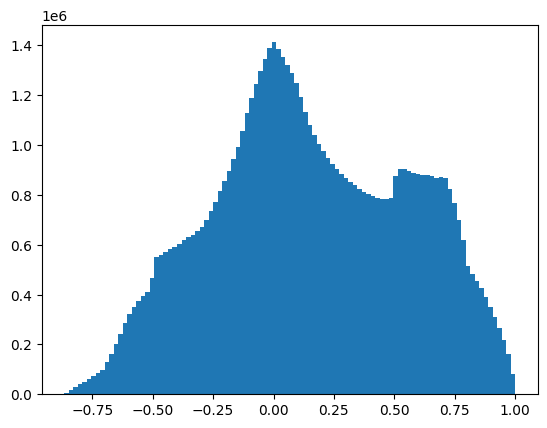

In [6]:
plt.hist(ee_pos_quat.flatten(), bins=100);